In [1]:
import math as mt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as clrs
plt.rcParams.update({"text.usetex": True})
import modplot
%matplotlib notebook

import energyflow as ef

### Read in the Open Data

This cell determines the jet $p_T$, $|\eta|$, and quality selections and reads in the datasets. The defaults are jets with $p_T\in[375,425]$ GeV and $|\eta|<1.9$ of "medium" quality. A small fraction of each dataset is used by default.

**Customize:** You can change the `specs` to any desired jet selection. Make sure to change the corresponding plot stamp description of the selection.

In [2]:
# use a fraction of the full datasets (amount=1.0 uses the full datasets)
amount = 0.01

# select jets with JEC-corrected pT in [375, 425] GeV and |eta| < 1.9, with "medium" quality
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']

# stamp description of the jet selections
legend_label_0 = r'AK5 Jets, $|\eta^{\rm jet}|<1.9$'
legend_label_1 = r'$p_T^{\rm jet}\in [375,425]$ GeV'

# load the CMS (cms), Pythia-generated (gen), and detector-simulated (sim) datasets
cms = ef.mod.load(*specs, dataset='cms', amount=amount, validate_files=True)
sim = ef.mod.load(*specs, dataset='sim', amount=amount, store_gens=False)
gen = ef.mod.load(*specs, dataset='gen', amount=amount)

# show the details of the CMS, SIM, and GEN datasets
#print(cms)
#print(sim)
#print(gen)

### SIM Data
Dataframe created below contains ::: jets_i + original index position + jets_f.
Having original index position of a jet in initial dataframe, allows to accurately get the pfcs after processing the dataframes.

In [3]:
# Create the Dataframe
sim_i_df = pd.DataFrame(sim.jets_i, columns=sim.jets_i_cols)

# Create a sample of index positions [0, 1, 2, 3, 4, .....,N-1 ,N]
col0 = np.linspace(0, len(sim.jets_i), num=len(sim.jets_i), dtype=int, endpoint=False)

# Insert those indexes into the Dataframe 
# Indexes are inserted after the final column of the original sim_df Dataframe
end = len(sim.jets_i[0])
sim_i_df.insert(end, 'index_pos', col0)

# Create a Dataframe for jets_f array
sim_f_df = pd.DataFrame(sim.jets_f, columns=sim.jets_f_cols)

# Concatenate the 2 Dataframes
sim_df = pd.concat([sim_i_df, sim_f_df], axis=1)

# Add a column for k-factors
sim_factors = ef.mod.kfactors('sim', sim.corr_jet_pts, sim.npvs)
sim_df = pd.concat([sim_df, pd.DataFrame(sim_factors, columns=['kfactor'])], axis=1)

# Show the final Dataframe
#sim_df.head(7)

# Find the duplicates and sort based also on jet_pt
key = sim_df.duplicated(subset=['rn', 'lbn', 'evn'], keep=False)
sim_multijetdf = sim_df[key]
sim_multijetdf = sim_multijetdf.sort_values(by=['rn', 'lbn', 'evn','jet_pt'], axis=0, ascending=[True, True, True, False], ignore_index=True)
sim_multijetdf.head(10)

###################################################

# If u want to check result, remove comment from below

#y = sim_multijetdf.value_counts(subset=['rn','lbn', 'evn']).to_frame(name='count').reset_index()
#y.loc[y['count'] == 2]
#y
####################################################

,fn,rn,lbn,evn,npv,quality,hard_pid,index_pos,jet_pt,jet_y,...,gen_jet_pt,gen_jet_y,gen_jet_phi,gen_jet_m,gen_jet_eta,hard_pt,hard_y,hard_phi,weight,kfactor
0,727,1,3,519,6,3,1,37283,399.900452,-1.014915,...,368.495347,-1.015617,6.115013,9.533290,-1.015874,370.320068,-1.015215,6.114893,0.000005,1.426286
1,727,1,3,519,6,3,2,37284,370.064056,-0.426476,...,397.436792,-0.423359,2.885531,48.480370,-0.426320,398.547760,-0.412661,2.882868,0.000005,1.418758
2,727,1,3,543,7,3,-1,37286,403.371063,-0.463280,...,416.432683,-0.462980,1.360069,22.358314,-0.463602,424.624878,-0.462326,1.359082,0.000005,1.231861
3,727,1,3,543,7,3,2,37287,365.361084,-1.425226,...,350.061606,-1.365593,4.277766,13.765034,-1.366271,370.141632,-1.417398,4.335003,0.000005,1.226136
4,727,1,3,596,5,3,2,37294,393.117737,-0.395765,...,374.996079,-0.395500,5.883945,36.051299,-0.397234,370.340790,-0.387822,5.882631,0.000005,1.597097
5,727,1,3,596,5,3,1,37295,356.195160,-1.224195,...,380.306487,-1.211859,2.743252,65.832116,-1.224246,379.471436,-1.226154,2.745354,0.000005,1.590633
6,727,1,3,598,5,3,2,37296,397.360962,0.121860,...,399.989073,0.120497,3.054855,24.778301,0.120727,394.783814,0.121861,3.057950,0.000005,1.598134
7,727,1,3,598,5,3,21,37297,368.829041,-1.580098,...,411.789391,-1.578472,6.215758,31.137120,-1.581091,411.356811,-1.576477,6.218165,0.000005,1.591569
8,727,1,3,623,4,3,21,37299,405.696228,0.537672,...,422.489068,0.543641,5.308948,32.941338,0.545145,443.373444,0.542849,5.305156,0.000005,1.720798
9,727,1,3,623,4,3,21,37300,403.338776,0.253836,...,413.473340,0.247769,2.244297,58.920335,0.250221,431.533539,0.234132,2.173787,0.000005,1.719851


### CMS Data

Dataframe created below contains ::: jets_i + original index position + jets_f.
Having original index position of a jet in initial dataframe, allows to accurately get the pfcs after processing the dataframes.

In [4]:
# Create the Dataframe
cms_i_df = pd.DataFrame(cms.jets_i, columns=cms.jets_i_cols)

# Create a sample of index positions [0, 1, 2, 3, 4, .....,N-1 ,N]
col0 = np.linspace(0, len(cms.jets_i), num=len(cms.jets_i), dtype=int, endpoint=False)

# Insert those indexes into the Dataframe 
# Indexes are inserted after the final column of the original cms_df Dataframe
end = len(cms.jets_i[0])
cms_i_df.insert(end, 'index_pos', col0)

# Create a Dataframe for jets_f array
cms_f_df = pd.DataFrame(cms.jets_f, columns=cms.jets_f_cols)

# Concatenate the 2 Dataframes
cms_df = pd.concat([cms_i_df, cms_f_df], axis=1)

# Show the final Dataframe
#cms_df.head(7)

# Find duplicate rows by 'run number', 'event number' and 'lumi-block number'. Then store them consequtively.
# For each event, jets sorted by pt-descending order.
key = cms_df.duplicated(subset=['rn', 'lbn', 'evn'], keep=False)
cms_multijetdf = cms_df[key]
cms_multijetdf = cms_multijetdf.sort_values(by=['rn', 'lbn', 'evn','jet_pt'], axis=0, ascending=[True, True, True, False], ignore_index=True)
cms_multijetdf.head(10)

###################################################

# If u want to check result, remove comment from below
#y = cms_multijetdf.value_counts(subset=['rn','lbn', 'evn']).to_frame(name='count').reset_index()
#y.loc[y['count'] == 2]
#y
####################################################

,fn,rn,lbn,evn,npv,quality,index_pos,jet_pt,jet_y,jet_phi,jet_m,jet_eta,jec,jet_area,jet_max_nef,weight
0,62,163270,19,11581000,6,3,44209,396.280579,-0.434044,4.061552,28.942925,-0.435132,1.040877,0.757972,0.391763,0.000008
1,62,163270,19,11581000,6,3,44210,383.399322,-0.461468,0.748706,45.129570,-0.464443,1.039648,0.787892,0.519139,0.000008
2,62,163270,20,12490642,6,3,44215,384.363769,0.255915,6.067917,31.169455,0.256737,1.033607,0.767945,0.250696,0.000008
3,62,163270,20,12490642,6,3,44216,383.563232,0.083641,2.925333,39.990425,0.084094,1.033942,0.767945,0.438273,0.000008
4,62,163270,21,12949566,10,3,44224,402.191925,0.418589,4.344069,66.703331,0.423989,1.036886,0.777918,0.146167,0.000008
5,62,163270,21,12949566,10,3,44225,363.443390,1.185422,1.175189,56.641331,1.195390,1.089859,0.767945,0.115382,0.000008
6,62,163270,23,14740127,3,3,44234,387.941589,0.579091,3.484608,27.396698,0.580391,1.053081,0.807838,0.776760,0.000008
7,62,163270,23,14740127,3,3,44235,351.839569,1.021082,0.327324,31.265890,1.024114,1.085891,0.767945,0.240945,0.000008
8,62,163270,28,17595971,7,3,44256,408.008667,-0.516772,2.622725,56.799912,-0.521350,1.041440,0.787892,0.228286,0.000008
9,62,163270,28,17595971,7,3,44257,397.614868,-0.725106,5.667046,41.824291,-0.728523,1.054892,0.777918,0.175959,0.000008


### Let's begin with CMS Data

In [46]:
# Pick an event (line number) from the above cms_multijetdf. 
Line = 10

# How many jets in that event
N = 2

# View how many jets there are in that event.
cms_multijetdf.iloc[Line : Line + 3]

,fn,rn,lbn,evn,npv,quality,index_pos,jet_pt,jet_y,jet_phi,jet_m,jet_eta,jec,jet_area,jet_max_nef,weight
10,62,163270,28,17658913,6,3,44253,379.462097,-0.796453,2.819134,72.022614,-0.808227,1.061700,0.797865,0.332601,0.000008
11,62,163270,28,17658913,6,3,44254,367.039001,0.237233,6.054230,33.735981,0.238214,1.029301,0.807838,0.450988,0.000008
12,62,163270,28,18010582,4,3,44249,410.939484,0.075977,5.638594,66.707535,0.076969,1.031684,0.767945,0.163849,0.000008


### View the pfcs arrays for these jets

Jet 1

In [47]:
N1 = cms_multijetdf['index_pos'].iloc[Line]
pfcs_jet1df = pd.DataFrame(cms.pfcs[N1], columns=cms.pfcs_cols)

print(f'There are {len(pfcs_jet1df)} pfcs in jet1')
pfcs_jet1df.head()

There are 63 pfcs in jet1


,pt,y,phi,m,pid,vertex
0,0.538447,-0.342619,3.019125,0.13957,-211.0,0.0
1,3.497996,-0.607182,3.272634,0.00000,130.0,0.0
2,0.273843,-1.283390,2.818309,0.00000,22.0,0.0
3,4.310225,-1.177110,3.114319,0.13957,-211.0,0.0
4,0.726877,-0.344812,2.993951,0.00000,22.0,0.0


Jet 2

In [48]:
N2 = cms_multijetdf['index_pos'].iloc[Line + 1]
pfcs_jet2df = pd.DataFrame(cms.pfcs[N2], columns=cms.pfcs_cols)

print(f'There are {len(pfcs_jet2df)} pfcs in jet2')
pfcs_jet2df.head()

There are 38 pfcs in jet2


,pt,y,phi,m,pid,vertex
0,0.715763,-0.143299,6.375124,0.13957,-211.0,0.0
1,0.684852,-0.047398,6.457501,0.00000,22.0,0.0
2,0.436640,0.430827,5.603749,0.13957,211.0,1.0
3,0.593580,-0.227730,6.088862,0.13957,-211.0,1.0
4,0.472919,0.407489,6.485294,0.00000,22.0,0.0


### Define a function to handle boundary conditions for phi $ [0 , 2\pi] \rightarrow [-\pi, \pi]$ 

In [49]:
def phi_boundary(phi):
    size = len(phi)
    for ii in range(size):
        while phi[ii] > mt.pi:
            phi[ii] -= 2*mt.pi
        while phi[ii] < -mt.pi:
            phi[ii] += 2*mt.pi
    
    return phi

In [50]:
# Pfcs dataframes as arrays
pfcs_for_jet1 = np.asarray(pfcs_jet1df)
pfcs_for_jet2 = np.asarray(pfcs_jet2df)

#1-d array for pfcs,jets_pt,y,phi 
pfcs1_pt = pfcs_for_jet1[:, 0]
pfcs1_y = pfcs_for_jet1[:, 1]
pfcs1_phi = pfcs_for_jet1[:, 2]

pfcs2_pt = pfcs_for_jet2[:, 0]
pfcs2_y = pfcs_for_jet2[:, 1]
pfcs2_phi = pfcs_for_jet2[:, 2]


#Appending the arrays to get one of 'em

pfcs_pt = np.concatenate((pfcs1_pt, pfcs2_pt))
pfcs_y = np.concatenate((pfcs1_y, pfcs2_y))
pfcs_phi = np.concatenate((pfcs1_phi, pfcs2_phi))

# Boundary conditions for phi
pfcs_phi = phi_boundary(pfcs_phi)

In [51]:
# Jet Dataframe as array
jet1 = np.asarray(cms_multijetdf.iloc[Line])
jet2 = np.asarray(cms_multijetdf.iloc[Line + 1])

# Column indexes
n1 = cms_df.columns.get_loc('jet_pt')
n2 = cms_df.columns.get_loc('jet_y')
n3 = cms_df.columns.get_loc('jet_phi')

jet1_pt = jet1[n1]
jet1_y = jet1[n2]
jet1_phi = jet1[n3]

jet2_pt = jet2[n1]
jet2_y = jet2[n2]
jet2_phi = jet2[n3]

#Appending the arrays to get one of 'em

jet_pt = np.array([jet1_pt, jet2_pt])
jet_y = np.array([jet1_y, jet2_y])
jet_phi = np.array([jet1_phi, jet2_phi])

# Boundary conditions for jet azimuthal angle
jet_phi = phi_boundary(jet_phi)
jet1_phi = jet_phi[0]
jet2_phi = jet_phi[1]

# Y-Phi scatter plot for pfcs and jets 
Size of each pfc is pt-weighted.

Size of each jet is weighted by a factor of 10*pt.

<IPython.core.display.Javascript object>


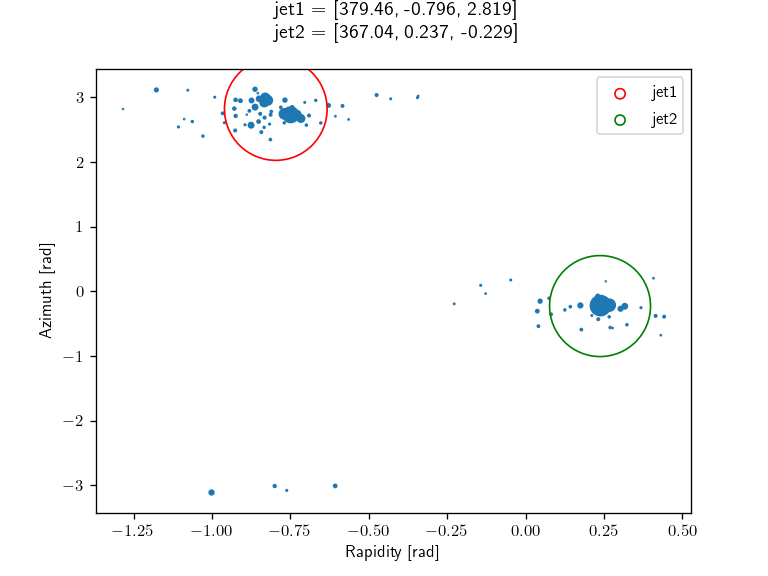

In [52]:
#The line connecting the 2 pfcs area is the jet connection vector

fig, ax = plt.subplots()
colors = clrs.Normalize
ax.scatter(pfcs_y, pfcs_phi, s=pfcs_pt, cmap = plt.cm.viridis)
ax.scatter(jet1_y, jet1_phi, s=10*jet1_pt, cmap = plt.cm.viridis, 
           facecolors='none', edgecolors='r', label='jet1')
ax.scatter(jet2_y, jet2_phi, s=10*jet2_pt, cmap = plt.cm.viridis,
           facecolors='none', edgecolors='g', label='jet2')

#Titles for staff
l1 = 'Scatter plot for jets and their constituents \n'
l2 = f'jet1 = [{round(jet1_pt, 2)}, {round(jet1_y, 3)}, {round(jet1_phi, 3)}]\n'
l3 = f'jet2 = [{round(jet2_pt, 2)}, {round(jet2_y, 3)}, {round(jet2_phi, 3)}]\n'

title = l1 + l2 + l3

ax.set_title(title)
ax.set_xlabel('Rapidity [rad]')
ax.set_ylabel('Azimuth [rad]')

ax.legend(loc='upper right', markerscale=0.1)
fig.show()

# Calculating pull vector for each jet and pull angle

# Define your pull vector function

In [53]:
#Pass 2 arrays that include as collumns pt|y|phi|mass
#Jet_array need to be [1, 4] and pfcs [N, :]
#Returns 1d array [y-component, phi-component]

def pull_vector(jet_array, pfcs_array):
    particle_pt = pfcs_array[:, 0]
    particle_y = pfcs_array[:,1]
    particle_phi = pfcs_array[:,2]
    
    jet_pt = jet_array[0]
    jet_y = jet_array[1]
    jet_phi = jet_array[2]
    pull_magn = 0
    plv = np.array([0., 0.])
    
    for i in range(len(particle_pt)):
        ratio = particle_pt[i] / jet_pt
        dy = particle_y[i] - jet_y
        dphi = particle_phi[i] - jet_phi
        pull_magn = ratio*((dy**2 + dphi**2)**(0.5))
        plv[0] += pull_magn*dy
        plv[1] += pull_magn*dphi
    
    return plv

### Define a function to calculate pull angle (dot product)--->currently not working properly

#Takes as arguments 1 jet pull vector, 
#another 2 jet vectors to construct the jet connection vector.
#Return a 1d array of pull angle [y, phi]

def pull_angle(jet_plv, jet_1, jet_2):
    connect12 = np.array([jet_2[1] - jet_1[1], jet_2[2] - jet_1[2]])
    numerator = np.dot(jet_plv, connect12)
    conn_norm = mt.sqrt(connect12[0]**2 + connect12[1]**2)
    plv_norm = mt.sqrt(jet_plv[0]**2 + jet_plv[1]**2)
    denominator = conn_norm*plv_norm
    return mt.acos(numerator/denominator)


### Define a function to calculate pull angle by comparing vector angles

In [54]:
# To calculate pull angle, pass connection vector angle and pull vector angle 

def pull_angle(angle1, angle2):
    delta_angle = angle2 - angle1
    if abs(delta_angle) <= mt.pi:
        return delta_angle
    else:
        return 2*mt.pi-abs(delta_angle)

### Define a function for calculating angles

In [55]:
def pick_angle(y, phi):
    r = mt.sqrt(y**2 + phi**2)
    sin = phi/r
    cos = y/r
    tan = phi/y
    if sin >= 0 and cos >= 0 :
        #print('1st quarter')
        return mt.acos(cos)
    elif sin >= 0 and cos <= 0 :
        #print('2nd quarter')
        return mt.acos(cos)
    elif sin <= 0 and cos <= 0 :
        #print('3rd quarter')
        return -mt.acos(cos)
    elif sin <= 0 and cos >= 0 :
        #print('4th quarter')
        return -mt.acos(cos)

In [56]:
#Pull vector function takes as arguments 1d array for jet vector and 2d array for pfcs

v1 = pull_vector(jet1[n1:n3+2], pfcs_for_jet1)
v2 = pull_vector(jet2[n1:n3+2], pfcs_for_jet2)

print(f'The pull vector for jet1 is : {v1}')
print(f'The pull vector for jet2 is : {v2}\n')

#The jet connection vector
connection12 = np.array([jet2_y - jet1_y, jet2_phi - jet1_phi])
connection21 = np.array([jet1_y - jet2_y, jet1_phi - jet2_phi])
print(f'Jet connection vector 1->2 coordinates : {connection21}')

# Calculate the angle of connection vector
# It will help to correctly visualize jet pull vector afterwards
y = connection12[0]
phi = connection12[1]
conn_angle12 = pick_angle(y, phi)

print(f'\nAngle of the jet_connection vector 1->2 in degrees : {mt.degrees(conn_angle12)}')

if conn_angle12 >= 0:
    conn_angle21 = conn_angle12 - mt.pi
else:
    conn_angle21 = conn_angle12 + mt.pi

print(f'Angle of the jet_connection vector 2->1 in degrees : {mt.degrees(conn_angle21)}\n')

#Pull angle function takes as arguments conn_vector angle and pull_vector angle
ang = pick_angle(v1[0], v1[1])
ang2 = pick_angle(v2[0], v2[1])

angle12 = pull_angle(conn_angle12, ang)
angle21 = pull_angle(conn_angle21, ang2)

print(f'Pull angle for jet 1 is {mt.degrees(angle12)}')
print(f'Pull angle for jet 2 is {mt.degrees(angle21)}\n')

The pull vector for jet1 is : [-0.0028502   0.00517737]
The pull vector for jet2 is : [-0.00162626 -0.00154793]

Jet connection vector 1->2 coordinates : [-1.03368638  3.04808925]

Angle of the jet_connection vector 1->2 in degrees : -71.26686523245911
Angle of the jet_connection vector 2->1 in degrees : 108.73313476754089

Pull angle for jet 1 is 169.8998505635239
Pull angle for jet 2 is 114.85331055111445



In [57]:
abs(conn_angle12) + abs(conn_angle21)==mt.pi

True

### Testing.........

<IPython.core.display.Javascript object>


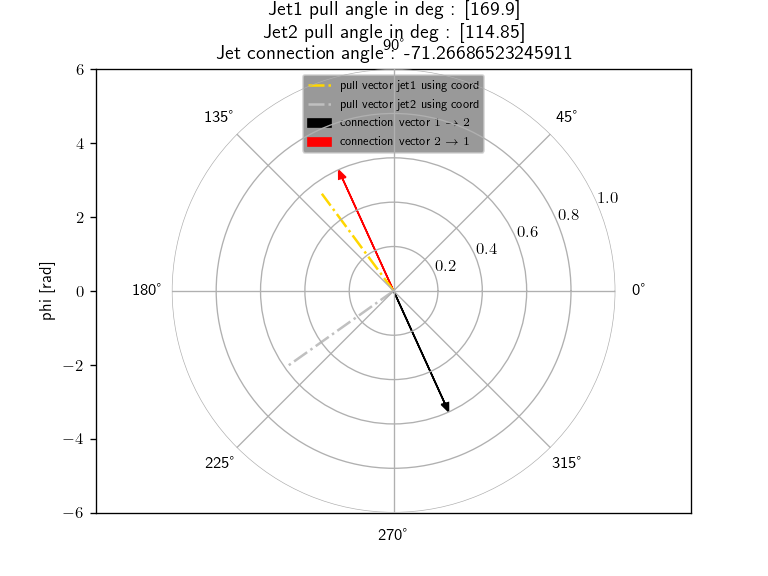

In [58]:
fig, ax = plt.subplots()

# Jet connection vector 1->2
x1 = np.array([0, connection12[0]])
y1 = np.array([0, connection12[1]])

ax.arrow(x1[0], y1[0], x1[1] - x1[0], y1[1] - y1[0], color='black',
         label=r'connection vector $1\rightarrow2$', head_width=0.15)

# Jet connection vector 2->1
x2 = np.array([0, connection21[0]])
y2 = np.array([0, connection21[1]])

ax.arrow(x2[0], y2[0], x2[1] - x2[0], y2[1] - y2[0], color='red',
         label=r'connection vector $2\rightarrow1$', head_width=0.15)


############################################################################

# Pull vector for jet1 using coordinates of vector
r=3
ang = pick_angle(v1[0], v1[1])
pullx = np.array([0, r*mt.cos(ang)])
pully = np.array([0, r*mt.sin(ang)])

ax.plot(pullx, pully, color='gold', linestyle='dashdot', label='pull vector jet1 using coord')

# Pull vector for jet2 using coordinates vector
r=3
ang2 = pick_angle(v2[0], v2[1])
pull2x = np.array([0, r*mt.cos(ang2)])
pull2y = np.array([0, r*mt.sin(ang2)])

plt.plot(pull2x, pull2y, color='silver', linestyle='dashdot', label='pull vector jet2 using coord')

#############################################################################
'''
# Pull vector for jet1 using pull angle
r=2
pullx = np.array([0, r*mt.cos(conn_angle12 - angle12)])
pully = np.array([0, r*mt.sin(conn_angle12 - angle12)])

ax.plot(pullx, pully, color='blue', linestyle='dotted', label='pull vector jet1 from pull angle')


# Pull vector for jet2 using pull angle
r=2
pull2x = np.array([0, r*mt.cos(angle21 + conn_angle21)])
pull2y = np.array([0, r*mt.sin(angle21 + conn_angle21)])

ax.plot(pull2x, pull2y, color='orange', linestyle='dotted', label='pull vector jet2 from pull angle')

#############################################################################
'''
# Axis limits
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])

ax.legend(fontsize='x-small', facecolor='grey', loc='upper center')
ax_polar = fig.add_subplot(polar=True, frameon=False, )

ax.get_xaxis().set_visible(False)
ax.xaxis.grid(True)

# Titles
l1 = f' Jet1 pull angle in deg : [{round(mt.degrees(angle12), 2)}]'
l2 = f'\n Jet2 pull angle in deg : [{round(mt.degrees(angle21), 2)}]'
l3 = f'\nJet connection angle : {mt.degrees(conn_angle12)}'
title = l1 + l2 + l3

ax.set_title(title)
ax.set_xlabel('y [rad]')
ax.set_ylabel('phi [rad]')


fig.show()

# Plotting everything together---->Scatter plot + Jets + Jet_connection vector + pull_vector

<IPython.core.display.Javascript object>


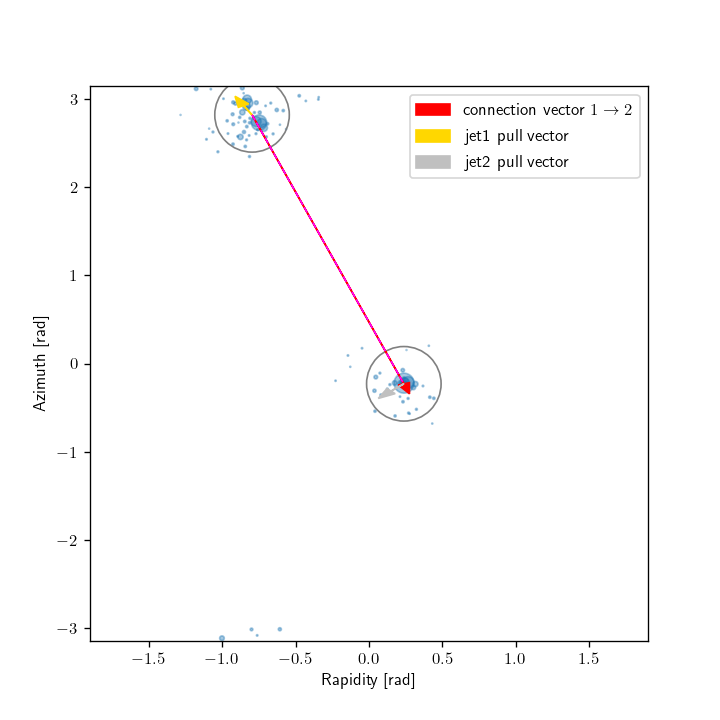

Pull angle in degrees for jet 1 is [169.9]
Pull angle in degrees for jet 2 is [114.853]



In [59]:
# Settings 
figsize = (6, 6)

fig, axes = plt.subplots(figsize=figsize)

#First pfcs
plt.scatter(pfcs_y, pfcs_phi, s=pfcs_pt, cmap = plt.cm.binary, alpha=0.4)

#Then jets 1 and 2---------->size === 10*jet_pt for clarity purposes
radius = 2000
axes.scatter(jet_y, jet_phi, s=radius, facecolors='none', edgecolors='grey')

r = 0.12                 # radius for pull vectors
arrow_head = 0.08
#Then jet connection line
axes.plot([jet1_y,jet2_y],[jet1_phi,jet2_phi], linewidth=1, color='magenta', linestyle='dashed')
axes.arrow(jet1_y, jet1_phi, jet2_y - jet1_y, jet2_phi- jet1_phi,
           head_width = arrow_head, color='red', label=r'connection vector $1\rightarrow2$')

##############################################################
##############################################################

#Then pull vectors for each jet
#make an array with x-components and another for y-components

# 1st pull vector
y = v1[0]
phi = v1[1]
ang1 = pick_angle(y, phi)

r1 = r
x1_comp = jet1_y
y1_comp = jet1_phi
dx1 = r1*mt.cos(ang)
dy1 = r1*mt.sin(ang)

axes.arrow(x1_comp, y1_comp, dx1, dy1, color='gold', 
         label='jet1 pull vector', head_width= arrow_head)

# 2nd pull vector
y = v2[0]
phi = v2[1]
ang2 = pick_angle(y, phi)

r2 = r
x2_comp = jet2_y
y2_comp = jet2_phi
dx2 = r2*mt.cos(ang2)
dy2 = r2*mt.sin(ang2)

axes.arrow(x2_comp, y2_comp, dx2, dy2, color='silver', 
         label='jet2 pull vector', head_width= arrow_head)

##############################################################
print(f'Pull angle in degrees for jet 1 is [{round(mt.degrees(angle12), 3)}]')
print(f'Pull angle in degrees for jet 2 is [{round(mt.degrees(angle21), 3)}]\n')
##############################################################

# Limits --- Be carefull with messing with this--spoils image ratio and thus angles of pull vectors shown
axes.set_ylim([-mt.pi, mt.pi])
axes.set_xlim([-1.9, 1.9])


#Titles
l1 = f'Jet connection vector is shown.\nPull angle for each jet is:'
l2 = f'\n cos(theta_1) = {mt.cos(angle12)}\n cos(theta_2) = {mt.cos(angle21)} '
label = l1 + l2
xlabel = 'Rapidity [rad]'
ylabel = 'Azimuth [rad]'

axes.set_xlabel(xlabel)
axes.set_ylabel(ylabel)
axes.legend()



fig.show()

### Another function to calculate angle between 2 vectors

In [42]:
# Takes as arguments 2 vectors

def dot_angle(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    return np.arccos(dot_product)

In [43]:
print(mt.degrees(dot_angle(connection12, v1)))
print(mt.degrees(dot_angle(connection21, v2)))

164.59870967919676
115.08002892755198
